In [1]:
"""
    Experimentation with neural networks on a datset of MRI covid/non-covid images.
    
    Created: 10/21/2020
    Author(s): Ben Flanders (brf97486)
    
    
    Potential source of getting all layer predictions: https://stackoverflow.com/questions/51677631/keras-tensorflow-get-predictions-or-output-of-all-layers-efficiently

"""

import cv2, random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *

from DataHandler import dataHandler


In [2]:
dh = dataHandler() # data handler object. See DataHandler.py for more information.

# ALTER HYPERPARAMETERS HERE
BATCH_SIZE = 512




In [3]:
dataset = dh.get_all_data_labeled(shuffle=True)

In [4]:
# check that all data is in place
assert len(dh.get_non_covid_data_fp()) == 397 and len(dh.get_covid_data_fp()) == 349 and len(dh.get_all_data_labeled()) == (397 + 349)

In [5]:
datapoint = dataset[0] # get some datapoint from the dataset
random_img = cv2.imread(datapoint[0])

Label:  0.0
filepath:  /home/brf97486/COVID-19-CT-image-analysis-CSCI_8955/data/CT_NonCOVID/887.png
image dimensions:  (362, 477, 3)
image datatype:  uint8
image max:  255
image min


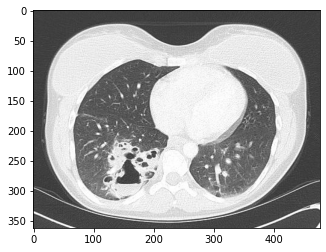

In [6]:
print("Label: ", datapoint[1])
print("filepath: ", datapoint[0])
print("image dimensions: ", random_img.shape)
print("image datatype: ", random_img.dtype)
print("image max: ", random_img.max())
print("image min")
plt.imshow(random_img)

In [7]:
# split the dataset into a train and test dataset

split_point = int(len(dataset) * .8 ) # 80 / 20 split

train_data = dataset[0:split_point]
test_data = dataset[split_point:]

assert len(train_data) + len(test_data) == (397 + 349) # ensure all expected data is present

train_data = train_data + train_data + train_data + train_data + train_data # when using the noise adder and random rotation then triple the datasets
random.shuffle(train_data)

In [8]:
# get the image data and load it into memory


train_X = np.asarray([dh.load_image(fp, resize=True, add_noise=True, randomly_rotate=True, grayscale=True) for (fp, label) in train_data]).astype('uint8')
train_y = np.asarray([label for (fp, label) in train_data]).astype('float16')

test_X = np.asarray([dh.load_image(fp, resize=True, add_noise=True, randomly_rotate=True, grayscale=True) for (fp, label) in test_data]).astype('uint8')
test_y = np.asarray([np.asarray(label) for (fp, label) in test_data]).astype('float16')

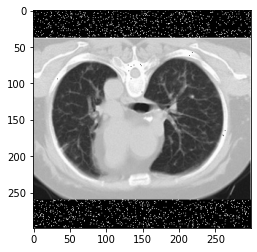

In [9]:
plt.imshow(train_X[0], cmap='gray')

In [10]:
#assert False

In [11]:
inception_model = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False)
inception_model.trainable = False
x = inception_model.output
x = Dropout(0.2)(x)
x = Dense(32, activation='relu', dtype=tf.float32)(x)
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(16, activation='relu', dtype=tf.float32)(x)
x = Dropout(0.5)(x)
#x = GlobalAveragePooling2D()(x)
#x = Dropout(0.5)(x)
prediction = Dense(1, activation='sigmoid', dtype=tf.float32)(x)


complete_model = tf.keras.Model(inputs=inception_model.input,outputs=prediction)

visualization_model = tf.keras.Model(inputs=inception_model.input, 
                                    outputs=[l.output for l in complete_model.layers[1:] if 'conv' in l.name])



complete_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.BinaryAccuracy(),)

# just the very last layer should be trainable for now
complete_model.layers[len(complete_model.layers)-1].trainable = True




In [12]:
complete_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
visualization_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [14]:
complete_model.fit(x=train_X, y=train_y, batch_size=BATCH_SIZE, validation_data=(test_X, test_y), epochs=400, )

Epoch 1/400
6/6 [==============================] - 126s 21s/step - loss: 5.8764 - binary_accuracy: 0.4977 - val_loss: 0.8792 - val_binary_accuracy: 0.5667
Epoch 2/400
6/6 [==============================] - 3s 538ms/step - loss: 1.8326 - binary_accuracy: 0.5309 - val_loss: 0.7861 - val_binary_accuracy: 0.5600
Epoch 3/400
6/6 [==============================] - 3s 541ms/step - loss: 0.8293 - binary_accuracy: 0.5131 - val_loss: 0.6809 - val_binary_accuracy: 0.5000
Epoch 4/400
6/6 [==============================] - 3s 541ms/step - loss: 0.7007 - binary_accuracy: 0.4883 - val_loss: 0.6754 - val_binary_accuracy: 0.5400
Epoch 5/400
6/6 [==============================] - 3s 541ms/step - loss: 0.6804 - binary_accuracy: 0.4795 - val_loss: 0.6757 - val_binary_accuracy: 0.5733
Epoch 6/400
6/6 [==============================] - 3s 543ms/step - loss: 0.6722 - binary_accuracy: 0.4879 - val_loss: 0.6644 - val_binary_accuracy: 0.5867
Epoch 7/400
6/6 [==============================] - 3s 541ms/step - los

6/6 [==============================] - 3s 548ms/step - loss: 0.5971 - binary_accuracy: 0.6403 - val_loss: 0.6109 - val_binary_accuracy: 0.6200
Epoch 54/400
6/6 [==============================] - 3s 549ms/step - loss: 0.5951 - binary_accuracy: 0.6336 - val_loss: 0.6072 - val_binary_accuracy: 0.6200
Epoch 55/400
6/6 [==============================] - 3s 549ms/step - loss: 0.5806 - binary_accuracy: 0.6477 - val_loss: 0.5913 - val_binary_accuracy: 0.6667
Epoch 56/400
6/6 [==============================] - 3s 548ms/step - loss: 0.5873 - binary_accuracy: 0.6601 - val_loss: 0.5828 - val_binary_accuracy: 0.6600
Epoch 57/400
6/6 [==============================] - 3s 549ms/step - loss: 0.5874 - binary_accuracy: 0.6376 - val_loss: 0.5905 - val_binary_accuracy: 0.6600
Epoch 58/400
6/6 [==============================] - 3s 549ms/step - loss: 0.5937 - binary_accuracy: 0.6299 - val_loss: 0.5912 - val_binary_accuracy: 0.6600
Epoch 59/400
6/6 [==============================] - 3s 549ms/step - loss: 0.5

6/6 [==============================] - 3s 550ms/step - loss: 0.5160 - binary_accuracy: 0.7232 - val_loss: 0.5693 - val_binary_accuracy: 0.6733
Epoch 106/400
6/6 [==============================] - 3s 550ms/step - loss: 0.5212 - binary_accuracy: 0.7161 - val_loss: 0.5742 - val_binary_accuracy: 0.6800
Epoch 107/400
6/6 [==============================] - 3s 550ms/step - loss: 0.5198 - binary_accuracy: 0.7117 - val_loss: 0.5951 - val_binary_accuracy: 0.6933
Epoch 108/400
6/6 [==============================] - 3s 549ms/step - loss: 0.5222 - binary_accuracy: 0.7158 - val_loss: 0.5584 - val_binary_accuracy: 0.6867
Epoch 109/400
6/6 [==============================] - 3s 549ms/step - loss: 0.5233 - binary_accuracy: 0.7252 - val_loss: 0.5640 - val_binary_accuracy: 0.6867
Epoch 110/400
6/6 [==============================] - 3s 549ms/step - loss: 0.5099 - binary_accuracy: 0.7174 - val_loss: 0.5661 - val_binary_accuracy: 0.6867
Epoch 111/400
6/6 [==============================] - 3s 549ms/step - los

6/6 [==============================] - 3s 550ms/step - loss: 0.4402 - binary_accuracy: 0.7903 - val_loss: 0.6158 - val_binary_accuracy: 0.7067
Epoch 158/400
6/6 [==============================] - 3s 550ms/step - loss: 0.4396 - binary_accuracy: 0.7758 - val_loss: 0.5376 - val_binary_accuracy: 0.7467
Epoch 159/400
6/6 [==============================] - 3s 551ms/step - loss: 0.4132 - binary_accuracy: 0.8050 - val_loss: 0.5203 - val_binary_accuracy: 0.7333
Epoch 160/400
6/6 [==============================] - 3s 551ms/step - loss: 0.4222 - binary_accuracy: 0.8027 - val_loss: 0.5186 - val_binary_accuracy: 0.7200
Epoch 161/400
6/6 [==============================] - 3s 550ms/step - loss: 0.4196 - binary_accuracy: 0.7990 - val_loss: 0.5237 - val_binary_accuracy: 0.7133
Epoch 162/400
6/6 [==============================] - 3s 549ms/step - loss: 0.4168 - binary_accuracy: 0.7960 - val_loss: 0.5601 - val_binary_accuracy: 0.7333
Epoch 163/400
6/6 [==============================] - 3s 549ms/step - los

6/6 [==============================] - 3s 550ms/step - loss: 0.3509 - binary_accuracy: 0.8339 - val_loss: 0.5199 - val_binary_accuracy: 0.7533
Epoch 210/400
6/6 [==============================] - 3s 549ms/step - loss: 0.3503 - binary_accuracy: 0.8443 - val_loss: 0.5848 - val_binary_accuracy: 0.7533
Epoch 211/400
6/6 [==============================] - 3s 549ms/step - loss: 0.3614 - binary_accuracy: 0.8366 - val_loss: 0.5104 - val_binary_accuracy: 0.7333
Epoch 212/400
6/6 [==============================] - 3s 550ms/step - loss: 0.3409 - binary_accuracy: 0.8470 - val_loss: 0.5241 - val_binary_accuracy: 0.7467
Epoch 213/400
6/6 [==============================] - 3s 550ms/step - loss: 0.3551 - binary_accuracy: 0.8379 - val_loss: 0.6018 - val_binary_accuracy: 0.7200
Epoch 214/400
6/6 [==============================] - 3s 551ms/step - loss: 0.3494 - binary_accuracy: 0.8500 - val_loss: 0.6346 - val_binary_accuracy: 0.7200
Epoch 215/400
6/6 [==============================] - 3s 550ms/step - los

6/6 [==============================] - 3s 551ms/step - loss: 0.3174 - binary_accuracy: 0.8648 - val_loss: 0.5450 - val_binary_accuracy: 0.7600
Epoch 262/400
6/6 [==============================] - 3s 549ms/step - loss: 0.3197 - binary_accuracy: 0.8604 - val_loss: 0.4960 - val_binary_accuracy: 0.7400
Epoch 263/400
6/6 [==============================] - 3s 551ms/step - loss: 0.3125 - binary_accuracy: 0.8685 - val_loss: 0.5023 - val_binary_accuracy: 0.7867
Epoch 264/400
6/6 [==============================] - 3s 551ms/step - loss: 0.3146 - binary_accuracy: 0.8671 - val_loss: 0.5213 - val_binary_accuracy: 0.7533
Epoch 265/400
6/6 [==============================] - 3s 550ms/step - loss: 0.3044 - binary_accuracy: 0.8782 - val_loss: 0.5390 - val_binary_accuracy: 0.7667
Epoch 266/400
6/6 [==============================] - 3s 549ms/step - loss: 0.2892 - binary_accuracy: 0.8782 - val_loss: 0.5877 - val_binary_accuracy: 0.7200
Epoch 267/400
6/6 [==============================] - 3s 550ms/step - los

6/6 [==============================] - 3s 550ms/step - loss: 0.2380 - binary_accuracy: 0.9087 - val_loss: 0.5855 - val_binary_accuracy: 0.7800
Epoch 314/400
6/6 [==============================] - 3s 550ms/step - loss: 0.2475 - binary_accuracy: 0.8966 - val_loss: 0.5753 - val_binary_accuracy: 0.7467
Epoch 315/400
6/6 [==============================] - 3s 551ms/step - loss: 0.2397 - binary_accuracy: 0.8997 - val_loss: 0.6036 - val_binary_accuracy: 0.7800
Epoch 316/400
6/6 [==============================] - 3s 551ms/step - loss: 0.2419 - binary_accuracy: 0.9060 - val_loss: 0.5501 - val_binary_accuracy: 0.7800
Epoch 317/400
6/6 [==============================] - 3s 550ms/step - loss: 0.2319 - binary_accuracy: 0.9020 - val_loss: 0.7144 - val_binary_accuracy: 0.7733
Epoch 318/400
6/6 [==============================] - 3s 550ms/step - loss: 0.2406 - binary_accuracy: 0.9050 - val_loss: 0.6286 - val_binary_accuracy: 0.7600
Epoch 319/400
6/6 [==============================] - 3s 549ms/step - los

6/6 [==============================] - 3s 550ms/step - loss: 0.1937 - binary_accuracy: 0.9235 - val_loss: 0.6009 - val_binary_accuracy: 0.7867
Epoch 366/400
6/6 [==============================] - 3s 549ms/step - loss: 0.1915 - binary_accuracy: 0.9242 - val_loss: 0.6578 - val_binary_accuracy: 0.7667
Epoch 367/400
6/6 [==============================] - 3s 550ms/step - loss: 0.1933 - binary_accuracy: 0.9258 - val_loss: 0.6006 - val_binary_accuracy: 0.7600
Epoch 368/400
6/6 [==============================] - 3s 551ms/step - loss: 0.2145 - binary_accuracy: 0.9191 - val_loss: 0.6161 - val_binary_accuracy: 0.7933
Epoch 369/400
6/6 [==============================] - 3s 550ms/step - loss: 0.1929 - binary_accuracy: 0.9275 - val_loss: 0.6303 - val_binary_accuracy: 0.7467
Epoch 370/400
6/6 [==============================] - 3s 550ms/step - loss: 0.1843 - binary_accuracy: 0.9265 - val_loss: 0.6404 - val_binary_accuracy: 0.7800
Epoch 371/400
6/6 [==============================] - 3s 550ms/step - los

In [15]:
# now fine tune the inception model itself
inception_model.trainable = True
complete_model.fit(x=train_X, y=train_y, batch_size=BATCH_SIZE, validation_data=(test_X, test_y), epochs=50)

Epoch 1/50
6/6 [==============================] - 3s 557ms/step - loss: 0.1878 - binary_accuracy: 0.9275 - val_loss: 0.6609 - val_binary_accuracy: 0.7600
Epoch 2/50
6/6 [==============================] - 3s 550ms/step - loss: 0.2056 - binary_accuracy: 0.9228 - val_loss: 0.6528 - val_binary_accuracy: 0.7867
Epoch 3/50
6/6 [==============================] - 3s 550ms/step - loss: 0.1875 - binary_accuracy: 0.9258 - val_loss: 0.6098 - val_binary_accuracy: 0.7533
Epoch 4/50
6/6 [==============================] - 3s 550ms/step - loss: 0.1869 - binary_accuracy: 0.9285 - val_loss: 0.6821 - val_binary_accuracy: 0.7667
Epoch 5/50
6/6 [==============================] - 3s 550ms/step - loss: 0.1809 - binary_accuracy: 0.9289 - val_loss: 0.6067 - val_binary_accuracy: 0.8000
Epoch 6/50
6/6 [==============================] - 3s 550ms/step - loss: 0.1666 - binary_accuracy: 0.9396 - val_loss: 0.6448 - val_binary_accuracy: 0.7800
Epoch 7/50
6/6 [==============================] - 3s 548ms/step - loss: 0.17

In [16]:
conv_lays = []

count = 0
    
for lay in complete_model.layers:
    if 'conv' in lay.name:
        conv_layer = lay
        conv_lays.append(lay)
        
print("Number of convolution layers: ", len(conv_lays))

Number of convolution layers:  94


In [17]:
kernel_images = conv_layer.kernel

(1, 1, 2048, 192)


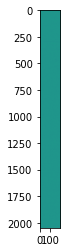

In [18]:
print(kernel_images.shape)

plt.imshow(kernel_images[0][0])

In [19]:

datapoint = test_data[len(test_data)-1]

img_data = np.asarray([dh.load_image(datapoint[0], resize=True)]).astype('uint8')

print("datapoint label: ", datapoint[1])
print("model prediction: ", complete_model.predict(img_data))

all_layer_outputs = visualization_model.predict(img_data)

datapoint label:  1.0
model prediction:  [[1.]]


In [20]:

for l in inception_layer.layers[2:]:
    if 'conv' in l.name:
        print(l.output) 


NameError: name 'inception_layer' is not defined

In [ ]:
layer_0_conv_out = all_layer_outputs[93][0]
layer_0_conv_out.shape
plt.imshow(layer_0_conv_out[:,:,0])